# Predictive Modelling of COVID-19 Vaccinations by County

## Table of Contents
1. Overview
2. Data Understanding
3. Data Preparation
4. Modelling
5. Interpreting Our Results
6. Impact of the Model
7. Next Steps

## 1. Overview

## 2. Data Understanding

We began with six datasets total, all providing data at the county-level. These datasets are provided below and in our data folder. Our target variable is the latest (as of May 2023) available cumulative data on completed primary series vaccinations by county, from the CDC. Our predictors are county-level demographic data: metro (urban) status from the same CDC dataset; 2020 Presidential election results from a github repository; race and age from the Census; poverty, median household income, and educational attainment from the USDA Economic Research Service.

## 3. Data Preparation

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

census_race = pd.read_csv('data/cc-est2022-all.csv', encoding="latin-1")
census_age = pd.read_csv('data/cc-est2022-agesex-all.csv')
vaccinations = pd.read_csv('data/COVID-19_Vaccinations_by_County.csv')
election = pd.read_csv('data/2020_US_County_Level_Presidential_Results.csv')
education = pd.read_excel('data/Education.xlsx')
poverty = pd.read_excel('data/PovertyEstimates.xlsx')

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_96793/1081371482.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccinations = pd.read_csv('data/COVID-19_Vaccinations_by_County.csv')


### 3.a. CDC Vaccination Data

In [70]:
# First seeing how many total counties we have
# Grouping by state to avoid repeats given that some counties have the same name
vaccinations.groupby(by="Recip_State")["Recip_County"].value_counts()
# Note the "Unknown County" -- we'll have to remove those

Recip_State  Recip_County              
AK           Aleutians East Borough        598
             Aleutians West Census Area    598
             Yakutat City and Borough      598
             Yukon-Koyukuk Census Area     598
             Wrangell City and Borough     598
                                          ... 
WY           Teton County                  598
             Uinta County                  598
             Washakie County               598
             Weston County                 598
             Unknown County                595
Name: count, Length: 3284, dtype: int64

In [71]:
print('Number of states in CDC dataset: ', vaccinations["Recip_State"].value_counts().__len__())
print('Number of states in election dataset: ', election["state_name"].value_counts().__len__())

Number of states in CDC dataset:  60
Number of states in election dataset:  51


We also have more than the expected 51 states (including DC), since other territories -- e.g., Guam, Puerto Rico, and the Virgin Islands -- are included in the dataset. Since 2020 presidential election results will be a large part of our analysis, and since these territories don't have representation in the electoral college, we'll end up removing them.

In a similar vein, compare the counties in the CDC dataset for Alaska to the corresponding districts in Alaska for the election dataset:

In [72]:
vaccinations["Recip_County"][vaccinations["Recip_State"] == "AK"].head()


108          Yukon-Koyukuk Census Area
410                 Bethel Census Area
538                Bristol Bay Borough
615    Southeast Fairbanks Census Area
621           Yakutat City and Borough
Name: Recip_County, dtype: object

In [73]:
election["county_name"][election["state_name"] == "Alaska"].head()

67    District 1
68    District 2
69    District 3
70    District 4
71    District 5
Name: county_name, dtype: object

Alaska, unlike other states, counts its voting totals according to districts for the state's lower legislative chamber. As a result we have a geographic mismatch that makes it extremely difficult to effectively utilize data for Alaska. As a result, we'll define two custom functions: the first to remove territories and Alaska from our datasets; the second to concatenate the county and state names, to allow us to easily join our different datasets.

In [74]:
# Function to remove territories and Alaska
def drop_terrs(df, state):
    df = df[(df[state] != "PR") & (df[state] != "GU") & (df[state] != "VI") & (df[state] != "AK")]
    return df

# Function to concatenate county and state
def County_with_State(df, county, state):
    df["County_with_State"] = df[county] + ", " + df[state]

# Running both on our vaccination data
vaccinations = drop_terrs(vaccinations, "Recip_State")
County_with_State(vaccinations, "Recip_County", "Recip_State")

vaccinations["Recip_State"].value_counts().__len__()

56

We'll still have to remove a few more territories from the vaccination data, but this is a good start.

In [75]:
vaccinations["Recip_State"].value_counts().sort_values(ascending=True).head(10)

Recip_State
UNK     308
MH      581
PW      588
AS      589
MP      591
FM      594
DC     1192
DE     2389
HI     3264
RI     3585
Name: count, dtype: int64

We'll drop the first 6. `UNK` refers to unknown states; `MH` refers to the Marshall Islands; `PW` refers to Palau; `AS` refers to American Samoa; `MP` refers to the Northern Mariana Islands; `FM` refers to the Federated States of Micronesia. (Note: we're not including this in the above function since the other datasets don't include these locations.)

In [76]:
vaccinations = vaccinations[(vaccinations["Recip_State"] != "UNK") & 
                            (vaccinations["Recip_State"] != "MH") & 
                            (vaccinations["Recip_State"] != "PW") &
                            (vaccinations["Recip_State"] != "AS") &
                            (vaccinations["Recip_State"] != "MP") &
                            (vaccinations["Recip_State"] != "FM")]
vaccinations["Recip_State"].value_counts().__len__()

50

In [77]:
# Also removing the "Unknown County" rows
vaccinations = vaccinations[vaccinations["Recip_County"] != "Unknown County"]
vaccinations["County_with_State"].value_counts()

County_with_State
Washburn County, WI        598
Winnebago County, IL       598
East Carroll Parish, LA    598
Madison County, AL         598
Slope County, ND           598
                          ... 
Chariton County, MO        598
Botetourt County, VA       598
Marion County, TN          598
Wallace County, KS         598
Santa Rosa County, FL      598
Name: count, Length: 3113, dtype: int64

This leaves us with 50 states (since we're keeping DC and dropping Alaska) and **3,113 unique counties**, each with 598 entries.

We'll now take a look at why exactly each county has so many entries:

In [78]:
vaccinations[vaccinations["County_with_State"] == "Saginaw County, MI"]

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
4563,05/03/2023,26145,18,Saginaw County,MI,94.0,104069.0,54.6,NaN,NaN,...,37414.0,15564.0,8.7,15394.0,9.4,15059.0,10.1,7884.0,21.1,"Saginaw County, MI"
7366,04/26/2023,26145,17,Saginaw County,MI,94.0,104066.0,54.6,NaN,NaN,...,37414.0,15535.0,8.7,15366.0,9.4,15034.0,10.0,7864.0,21.0,"Saginaw County, MI"
10458,04/19/2023,26145,16,Saginaw County,MI,94.0,104063.0,54.6,NaN,NaN,...,37414.0,15504.0,8.6,15336.0,9.4,15004.0,10.0,7843.0,21.0,"Saginaw County, MI"
15810,04/12/2023,26145,15,Saginaw County,MI,94.1,104065.0,54.6,NaN,NaN,...,37414.0,15523.0,8.6,15357.0,9.4,15025.0,10.0,7840.0,21.0,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949775,12/17/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"
1951790,12/16/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"
1954312,12/15/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"
1959148,12/14/2020,26145,51,Saginaw County,MI,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Saginaw County, MI"


For our purposes, we just want the percentage of everyone in the county who has completed their primary vaccination series -- so we will simply take the most recent data, from 05/10/2023.

In [79]:
vaccinations = vaccinations[(vaccinations["Date"] == "05/10/2023")]
vaccinations

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct,County_with_State
0,05/10/2023,55129,19,Washburn County,WI,96.7,11123.0,70.8,11097.0,73.9,...,4304.0,3978.0,26.5,3955.0,28.6,3899.0,30.6,2588.0,60.1,"Washburn County, WI"
1,05/10/2023,19173,19,Taylor County,IA,97.3,3149.0,51.4,3145.0,55.0,...,1392.0,841.0,14.7,841.0,16.3,834.0,17.8,588.0,42.2,"Taylor County, IA"
2,05/10/2023,36059,19,Nassau County,NY,97.5,1391226.0,95.0,1384503.0,95.0,...,246690.0,236202.0,18.4,231748.0,19.8,224931.0,21.1,109947.0,44.6,"Nassau County, NY"
3,05/10/2023,48281,19,Lampasas County,TX,98.9,11678.0,54.5,11660.0,57.4,...,4322.0,1951.0,9.6,1947.0,10.5,1925.0,11.5,1229.0,28.4,"Lampasas County, TX"
4,05/10/2023,26145,19,Saginaw County,MI,94.0,104075.0,54.6,NaN,NaN,...,37414.0,15618.0,8.7,15448.0,9.4,15112.0,10.1,7921.0,21.2,"Saginaw County, MI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,05/10/2023,29153,19,Ozark County,MO,91.3,3762.0,41.0,3760.0,42.9,...,2684.0,732.0,8.4,730.0,9.0,724.0,9.8,512.0,19.1,"Ozark County, MO"
3279,05/10/2023,46065,19,Hughes County,SD,96.7,16373.0,93.4,16308.0,95.0,...,3158.0,3659.0,22.4,3601.0,24.7,3499.0,26.3,1857.0,58.8,"Hughes County, SD"
3280,05/10/2023,26027,19,Cass County,MI,94.0,26815.0,51.8,NaN,NaN,...,11149.0,3330.0,6.8,3293.0,7.3,3219.0,7.8,1822.0,16.3,"Cass County, MI"
3281,05/10/2023,32001,19,Churchill County,NV,95.1,16252.0,65.2,16164.0,69.5,...,4759.0,2576.0,11.1,2544.0,12.1,2475.0,12.9,1439.0,30.2,"Churchill County, NV"


We're left with 3,113 rows, corresponding to 1 entry per unique county.

In [80]:
"""
From this dataset, we just want to include:
* Date
* County_with_State
* Series_Complete_Pop_Pct
* Metro_status
"""

vaccinations = vaccinations[["Date", "County_with_State", "Series_Complete_Pop_Pct", "Metro_status"]]
vaccinations

,Date,County_with_State,Series_Complete_Pop_Pct,Metro_status
0,05/10/2023,"Washburn County, WI",65.7,Non-metro
1,05/10/2023,"Taylor County, IA",48.2,Non-metro
2,05/10/2023,"Nassau County, NY",86.9,Metro
3,05/10/2023,"Lampasas County, TX",46.7,Metro
4,05/10/2023,"Saginaw County, MI",54.1,Metro
...,...,...,...,...
3278,05/10/2023,"Ozark County, MO",33.3,Non-metro
3279,05/10/2023,"Hughes County, SD",76.8,Non-metro
3280,05/10/2023,"Cass County, MI",45.7,Metro
3281,05/10/2023,"Churchill County, NV",56.3,Non-metro


### 3.b. Presidential Election Data

In [81]:
election.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [82]:
# Adding a third_party column
election["votes_third_party"] = election["total_votes"] - election["votes_dem"] - election["votes_gop"]

# Rounding percentages
election["per_third_party"] = round(100 * election["votes_third_party"] / election["total_votes"], 1)
election['per_gop'] = round(100 * election['per_gop'], 1)
election['per_dem'] = round(100 * election['per_dem'], 1)


In [83]:
# Adding a state abbreviation column
# Necessary for our drop_terrs and County_with_State functions to work
# adding a state_abbrev column
state_abbrevs = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

election["state_abbrev"] = election["state_name"].map(state_abbrevs)
election["state_abbrev"].head()

0    AL
1    AL
2    AL
3    AL
4    AL
Name: state_abbrev, dtype: object

In [84]:
election = drop_terrs(election, "state_abbrev")
County_with_State(election, "county_name", "state_abbrev")
num_states = election["state_abbrev"].value_counts().__len__()
num_counties = election["County_with_State"].value_counts().__len__()

print('Number of states in election dataset: ', num_states)
print('Number of unique counties in election dataset: ', num_counties)

Number of states in election dataset:  50
Number of unique counties in election dataset:  3112


We're going to have to compare which counties appear in two datasets a lot, so we'll define a function that allows us to do that quickly:

In [85]:
# Function to automatically compare difference in counties:
def check_overlap(df1, df2, column):
    vc1 = pd.DataFrame(df1[column])
    vc2 = pd.DataFrame(df2[column])
    combined = pd.merge(vc1, vc2, how="outer", indicator=True)
    combined_right = combined[combined["_merge"] == "right_only"]
    combined_left = combined[combined["_merge"] == "left_only"]
    return combined_right.value_counts(), combined_left.value_counts()

check_overlap(election, vaccinations, "County_with_State")

(County_with_State    _merge    
 Dona Ana County, NM  right_only    1
 Kalawao County, HI   right_only    1
 La Salle Parish, LA  right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Doña Ana County, NM  left_only    1
 LaSalle Parish, LA   left_only    1
 Name: count, dtype: int64)

In [86]:
election

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,votes_third_party,per_third_party,state_abbrev,County_with_State
0,Alabama,1001,Autauga County,19838,7503,27770,12335,71.4,27.0,0.444184,429,1.5,AL,"Autauga County, AL"
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,76.2,22.4,0.537623,1557,1.4,AL,"Baldwin County, AL"
2,Alabama,1005,Barbour County,5622,4816,10518,806,53.5,45.8,0.076631,80,0.8,AL,"Barbour County, AL"
3,Alabama,1007,Bibb County,7525,1986,9595,5539,78.4,20.7,0.577280,84,0.9,AL,"Bibb County, AL"
4,Alabama,1009,Blount County,24711,2640,27588,22071,89.6,9.6,0.800022,237,0.9,AL,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,73.7,23.0,0.506294,551,3.3,WY,"Sweetwater County, WY"
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,29.6,67.1,-0.375213,488,3.3,WY,"Teton County, WY"
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,79.7,16.9,0.628058,315,3.4,WY,"Uinta County, WY"
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,80.9,16.2,0.646560,116,2.9,WY,"Washakie County, WY"


In [87]:
# Renaming the different county names to match
election["County_with_State"] = election["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
election["county_name"] = election["county_name"].replace("Doña Ana County", "Dona Ana County")
election["County_with_State"] = election["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")
election["county_name"] = election["county_name"].replace("LaSalle Parish", "La Salle Parish")

# Manually imputing the values for Kalawao County, HI
election.loc[-1] = {"state_name": "Hawaii", "county_name": "Kalawao County", "total_votes": 24, "votes_dem": 23, "votes_gop": 1, "votes_third_party": 0, "per_dem": 95.8, "per_gop": 4.2, "per_third_party": 0, "state_abbrev": "HI", "County_with_State": "Kalawao County, HI"}


In [88]:
election[election["County_with_State"] == "Kalawao County, HI"]

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,votes_third_party,per_third_party,state_abbrev,County_with_State
-1,Hawaii,NaN,Kalawao County,1,23,24,NaN,4.2,95.8,NaN,0,0.0,HI,"Kalawao County, HI"


In [89]:
# gets us back to 3,113 counties
election["County_with_State"].value_counts().__len__()

3113

In [90]:
# Just selecting the columns we want
election = election[["per_gop", "per_dem", "per_third_party", "County_with_State"]]
election.head()

,per_gop,per_dem,per_third_party,County_with_State
0,71.4,27.0,1.5,"Autauga County, AL"
1,76.2,22.4,1.4,"Baldwin County, AL"
2,53.5,45.8,0.8,"Barbour County, AL"
3,78.4,20.7,0.9,"Bibb County, AL"
4,89.6,9.6,0.9,"Blount County, AL"


In [91]:
election.isna().sum()

per_gop              0
per_dem              0
per_third_party      0
County_with_State    0
dtype: int64

#### 3.b.ii. Creating the Combined DataFrame

In [92]:
# Making the combined df

df = pd.merge(election, vaccinations, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro
...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro


### 3.c. Poverty Data

In [93]:
poverty.head()

,"Poverty estimates for U.S., States, and counties, 2021",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,"Source: U.S. Department of Commerce, Bureau of...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"For definitions of rural classifications, see ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"This table was prepared by USDA, Economic Rese...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
4,00000,US,United States,NaN,NaN,NaN,NaN,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6


In [94]:
# Fixing column names and removing the initial rows
poverty.columns = poverty.iloc[3]
poverty.drop(poverty.index[0:5], inplace=True)

# Dropping territories and Alaska
poverty = drop_terrs(poverty, "Stabr")

# Creating our County_with_State column
County_with_State(poverty, "Area_name", "Stabr")
poverty.head()

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,800848,782169,819527,...,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6,"Alabama, AL"
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"


In [95]:
# Checking overlap with combined df
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 Alabama, AL          right_only    1
 Oregon, OR           right_only    1
 Montana, MT          right_only    1
 Nebraska, NE         right_only    1
 Nevada, NV           right_only    1
 New Hampshire, NH    right_only    1
 New Jersey, NJ       right_only    1
 New Mexico, NM       right_only    1
 New York, NY         right_only    1
 North Carolina, NC   right_only    1
 North Dakota, ND     right_only    1
 Ohio, OH             right_only    1
 Oklahoma, OK         right_only    1
 Pennsylvania, PA     right_only    1
 Mississippi, MS      right_only    1
 Rhode Island, RI     right_only    1
 South Carolina, SC   right_only    1
 South Dakota, SD     right_only    1
 Tennessee, TN        right_only    1
 Texas, TX            right_only    1
 Utah, UT             right_only    1
 Vermont, VT          right_only    1
 Virginia, VA         right_only    1
 Washington, WA       right_only    1
 West Virginia, WV    right_only    1
 Wisconsin, WI   

In [96]:
# The dataset includes combined data for each state, so we'll remove those.
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
poverty.drop(poverty.index[poverty["Area_name"].isin(state_names)], inplace=True)
poverty

3,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021,County_with_State
6,01001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,NaN,NaN,NaN,NaN,NaN,NaN,"Autauga County, AL"
7,01003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,NaN,NaN,NaN,NaN,NaN,NaN,"Baldwin County, AL"
8,01005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,NaN,NaN,NaN,NaN,NaN,NaN,"Barbour County, AL"
9,01007,AL,Bibb County,1,1,1,1,4204,3324,5084,...,48454,42438,54470,NaN,NaN,NaN,NaN,NaN,NaN,"Bibb County, AL"
10,01009,AL,Blount County,1,1,1,1,6992,5516,8468,...,56894,52632,61156,NaN,NaN,NaN,NaN,NaN,NaN,"Blount County, AL"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,56037,WY,Sweetwater County,5,8,5,8,3761,3048,4474,...,74677,66928,82426,NaN,NaN,NaN,NaN,NaN,NaN,"Sweetwater County, WY"
3195,56039,WY,Teton County,7,8,7,8,1392,1070,1714,...,102709,90132,115286,NaN,NaN,NaN,NaN,NaN,NaN,"Teton County, WY"
3196,56041,WY,Uinta County,7,8,7,8,1917,1457,2377,...,70162,62206,78118,NaN,NaN,NaN,NaN,NaN,NaN,"Uinta County, WY"
3197,56043,WY,Washakie County,7,11,7,11,773,579,967,...,62176,55415,68937,NaN,NaN,NaN,NaN,NaN,NaN,"Washakie County, WY"


In [97]:
# DC is listed twice, so only keeping the first instance
# Gets us to our 3,113 unique counties
poverty = poverty.drop_duplicates(subset=["County_with_State"], keep="first")
poverty["County_with_State"].value_counts().__len__()

3113

In [98]:
"""
From the poverty dataset, we only want to include the following columns:
* PCTPOVALL_2021, the overall percentage of people in poverty in 2021
* MEDHHINC_2021, the "[e]stimate of median household income 2021"
* County_with_State
"""

poverty = poverty[["PCTPOVALL_2021", "MEDHHINC_2021", "County_with_State"]]
poverty

3,PCTPOVALL_2021,MEDHHINC_2021,County_with_State
6,10.7,66444,"Autauga County, AL"
7,10.8,65658,"Baldwin County, AL"
8,23,38649,"Barbour County, AL"
9,20.6,48454,"Bibb County, AL"
10,12,56894,"Blount County, AL"
...,...,...,...
3194,9.2,74677,"Sweetwater County, WY"
3195,5.9,102709,"Teton County, WY"
3196,9.4,70162,"Uinta County, WY"
3197,10.2,62176,"Washakie County, WY"


In [99]:
# Checking overlap with our combined df:
check_overlap(df, poverty, "County_with_State")

(County_with_State    _merge    
 De Kalb County, IN   right_only    1
 DeBaca County, NM    right_only    1
 La Porte County, IN  right_only    1
 La Salle County, IL  right_only    1
 Lagrange County, IN  right_only    1
 Mc Kean County, PA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 De Baca County, NM   left_only    1
 DeKalb County, IN    left_only    1
 LaGrange County, IN  left_only    1
 LaPorte County, IN   left_only    1
 LaSalle County, IL   left_only    1
 McKean County, PA    left_only    1
 Name: count, dtype: int64)

In [100]:
# Fixing county names
poverty["County_with_State"] = poverty["County_with_State"].replace("De Kalb County, IN", "DeKalb County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("DeBaca County, NM", "De Baca County, NM")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Porte County, IN", "LaPorte County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("La Salle County, IL", "LaSalle County, IL")
poverty["County_with_State"] = poverty["County_with_State"].replace("Lagrange County, IN", "LaGrange County, IN")
poverty["County_with_State"] = poverty["County_with_State"].replace("Mc Kean County, PA", "McKean County, PA")

check_overlap(df, poverty, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [101]:
# Merging with our combined dataframe:
df = pd.merge(df, poverty, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894
...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509


### 3.d. Census: Race

In [102]:
census_race.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,58802,28761,30041,...,854,734,112,97,40,30,22,24,19,11
1,50,1,1,Alabama,Autauga County,1,1,3443,1790,1653,...,83,54,14,9,3,1,9,1,3,1
2,50,1,1,Alabama,Autauga County,1,2,3613,1849,1764,...,81,68,5,8,7,3,0,1,1,2
3,50,1,1,Alabama,Autauga County,1,3,4131,2121,2010,...,81,81,10,10,1,3,2,2,2,1
4,50,1,1,Alabama,Autauga County,1,4,3963,2003,1960,...,72,70,8,9,5,2,2,4,3,2


In [103]:
# Creating state abbreviations and County_with_State column
census_race["state_abbrev"] = census_race["STNAME"].map(state_abbrevs)
County_with_State(census_race, "CTYNAME", "state_abbrev")

# Removing Alaska and other territories
census_race = drop_terrs(census_race, "state_abbrev")

# Also dropping CT because they changed from counties to different administrative districts
census_race = census_race[census_race["state_abbrev"] != "CT"]

Note: because CT stopped using counties in the census in 2022, we are going to use other data.
[wiki link](https://en.wikipedia.org/wiki/List_of_counties_in_Connecticut)

In [104]:
# Including all age groups
census_race = census_race[census_race["AGEGRP"] == 0]
# Using year 2022
census_race = census_race[census_race["YEAR"] == 4]

In [105]:
# racial categories were broken down by sex; recombining them.
census_race["WA"] = round(100 * (census_race["WA_MALE"] + census_race["WA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["BA"] = round(100 * (census_race["BA_MALE"] + census_race["BA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["IA"] = round(100 * (census_race["IA_MALE"] + census_race["IA_FEMALE"])/census_race["TOT_POP"], 1)
census_race["AAPI"] = round(100 * (census_race["AA_MALE"] + census_race["NA_MALE"] +  census_race["AA_FEMALE"] + census_race["NA_FEMALE"])/census_race["TOT_POP"], 1)
census_race.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,state_abbrev,County_with_State,WA,BA,IA,AAPI
57,50,1,1,Alabama,Autauga County,4,0,59759,29105,30654,...,23,22,22,19,AL,"Autauga County, AL",74.8,21.4,0.5,1.3
133,50,1,3,Alabama,Baldwin County,4,0,246435,120164,126271,...,118,132,88,86,AL,"Baldwin County, AL",87.4,8.4,0.8,1.2
209,50,1,5,Alabama,Barbour County,4,0,24706,13064,11642,...,10,9,33,18,AL,"Barbour County, AL",49.2,47.7,0.7,0.7
285,50,1,7,Alabama,Bibb County,4,0,22005,11775,10230,...,8,10,19,6,AL,"Bibb County, AL",76.5,21.0,0.6,0.4
361,50,1,9,Alabama,Blount County,4,0,59512,29583,29929,...,15,29,37,28,AL,"Blount County, AL",95.4,1.9,0.6,0.6


In [106]:
# link: https://portal.ct.gov/DPH/Health-Information-Systems--Reporting/Population/Annual-State-County-Population-with-Demographics-for-2000-2019
# https://docs.google.com/spreadsheets/d/1ah9hCG5YFZtguc8Xabcix1ppcR4MWhNh2fq3cyWJ18I/edit?usp=sharing
census_race = census_race[["WA", "BA", "IA", "AAPI", "County_with_State"]]
census_race.loc[238869] = [79.5, 13.7, 0.6, 6.2, "Fairfield County, CT"]
census_race.loc[238870] = [76.2, 16.7, 0.7, 6.4, "Hartford County, CT"]
census_race.loc[238871] = [94.3, 2.8, 0.4, 2.4, "Litchfield County, CT"]
census_race.loc[238872] = [89.8, 6.2, 0.3, 3.6, "Middlesex County, CT"]
census_race.loc[238873] = [78.5, 16.2, 0.7, 4.6, "New Haven County, CT"]
census_race.loc[238874] = [85.4, 8.4, 1.4, 4.8, "New London County, CT"]
census_race.loc[238875] = [89.7, 4.4, 0.3, 5.5, "Tolland County, CT"]
census_race.loc[238876] = [93.4, 3.9, 0.9, 1.8, "Windham County, CT"]
census_race.tail(10)


,WA,BA,IA,AAPI,County_with_State
238849,94.4,0.5,1.7,1.0,"Washakie County, WY"
238925,92.8,0.8,2.1,1.5,"Weston County, WY"
238869,79.5,13.7,0.6,6.2,"Fairfield County, CT"
238870,76.2,16.7,0.7,6.4,"Hartford County, CT"
238871,94.3,2.8,0.4,2.4,"Litchfield County, CT"
238872,89.8,6.2,0.3,3.6,"Middlesex County, CT"
238873,78.5,16.2,0.7,4.6,"New Haven County, CT"
238874,85.4,8.4,1.4,4.8,"New London County, CT"
238875,89.7,4.4,0.3,5.5,"Tolland County, CT"
238876,93.4,3.9,0.9,1.8,"Windham County, CT"


In [107]:
check_overlap(df, census_race, "County_with_State")

(County_with_State    _merge    
 Doña Ana County, NM  right_only    1
 LaSalle Parish, LA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Dona Ana County, NM  left_only    1
 La Salle Parish, LA  left_only    1
 Name: count, dtype: int64)

In [108]:
census_race["County_with_State"] = census_race["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_race["County_with_State"] = census_race["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

check_overlap(df, census_race, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [109]:
df = pd.merge(df, census_race, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5


### 3.e. Census: Age

In [110]:
# Adding state abbreviations and County_with_State column
census_age["state_abbrev"] = census_age["STNAME"].map(state_abbrevs)
County_with_State(census_age, "CTYNAME", "state_abbrev")

# Removing Alaska and other territories
census_age = drop_terrs(census_age, "state_abbrev")

# Dropping CT for same reasons as above
census_age = census_age[census_age["state_abbrev"] != "CT"]

# Using the most recent year
census_age = census_age[census_age["YEAR"] == 4]

# Only including median age and County_with_State
census_age = census_age[["MEDIAN_AGE_TOT", "County_with_State"]]
census_age

,MEDIAN_AGE_TOT,County_with_State
3,39.2,"Autauga County, AL"
7,44.1,"Baldwin County, AL"
11,41.5,"Barbour County, AL"
15,40.9,"Bibb County, AL"
19,41.2,"Blount County, AL"
...,...,...
12559,37.7,"Sweetwater County, WY"
12563,41.0,"Teton County, WY"
12567,38.0,"Uinta County, WY"
12571,44.8,"Washakie County, WY"


In [111]:
# Imputing state-wide median CT age per county -- https://data.census.gov/profile/Connecticut?g=040XX00US09
# County-specific median age could not be located.
census_age.loc[12576] = [40.9, "Fairfield County, CT"]
census_age.loc[12577] = [40.9, "Hartford County, CT"]
census_age.loc[12578] = [40.9, "Litchfield County, CT"]
census_age.loc[12579] = [40.9, "Middlesex County, CT"]
census_age.loc[12580] = [40.9, "New Haven County, CT"]
census_age.loc[12581] = [40.9, "New London County, CT"]
census_age.loc[12582] = [40.9, "Tolland County, CT"]
census_age.loc[12583] = [40.9, "Windham County, CT"]

census_age.tail(10)

,MEDIAN_AGE_TOT,County_with_State
12571,44.8,"Washakie County, WY"
12575,44.5,"Weston County, WY"
12576,40.9,"Fairfield County, CT"
12577,40.9,"Hartford County, CT"
12578,40.9,"Litchfield County, CT"
12579,40.9,"Middlesex County, CT"
12580,40.9,"New Haven County, CT"
12581,40.9,"New London County, CT"
12582,40.9,"Tolland County, CT"
12583,40.9,"Windham County, CT"


In [112]:
check_overlap(df, census_age, "County_with_State")

(County_with_State    _merge    
 Doña Ana County, NM  right_only    1
 LaSalle Parish, LA   right_only    1
 Name: count, dtype: int64,
 County_with_State    _merge   
 Dona Ana County, NM  left_only    1
 La Salle Parish, LA  left_only    1
 Name: count, dtype: int64)

In [113]:
census_age["County_with_State"] = census_age["County_with_State"].replace("Doña Ana County, NM", "Dona Ana County, NM")
census_age["County_with_State"] = census_age["County_with_State"].replace("LaSalle Parish, LA", "La Salle Parish, LA")

In [114]:
df = pd.merge(df, census_age, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5,44.5


### 3.f. Education

In [115]:
education.head()

,"Educational attainment for adults age 25 and older for the U.S., States, and counties, 1970–2021",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,"Note: For 1970 and 1980, the share of adults w...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Source: USDA, Economic Research Service using ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Federal Information Processing Standard (FIPS)...,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,Percent of adults completing some college or a...,Percent of adults with a bachelor's degree or ...,"Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21",Percent of adults with less than a high school...,Percent of adults with a high school diploma o...,Percent of adults completing some college or a...,Percent of adults with a bachelor's degree or ...
3,00000,US,United States,NaN,NaN,NaN,NaN,52373312,34158051,11650730,...,28.993579,28.484955,25050356,59636386,64656741,75808834,11.12596,26.48713,28.716889,33.670022
4,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,29.022866,22.264896,430047,1041209,1032122,910425,12.5973,30.499973,30.233789,26.668938


In [116]:
# Fixing columns and deleting initial rows
education.columns = education.iloc[2]
education.drop(education.index[0:4], inplace=True)
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2008-12","Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21"
4,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,29.022866,22.264896,430047,1041209,1032122,910425,12.5973,30.499973,30.233789,26.668938
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,29.618142,21.707831,4126,12977,11367,11144,10.41551,32.758621,28.694401,28.131469
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,31.819503,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,25.771784,14.524286,4378,6600,5010,2007,24.32898,36.676855,27.841067,11.153098
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,25.538085,8.996005,3125,7052,3967,1913,19.461917,43.91854,24.705736,11.913807


In [117]:
# Dropping the state-wide data
education.drop(education.index[education["Area name"].isin(state_names)], inplace=True)
# Removing Alaska and other territories
education = drop_terrs(education, "State")
# Creating County_with_State column
County_with_State(education, "Area name", "State")
education.head()

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults with a bachelor's degree or higher, 2008-12","Less than a high school diploma, 2017-21","High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,21.707831,4126,12977,11367,11144,10.41551,32.758621,28.694401,28.131469,"Autauga County, AL"
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,27.741591,14555,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL"
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,14.524286,4378,6600,5010,2007,24.32898,36.676855,27.841067,11.153098,"Barbour County, AL"
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,8.996005,3125,7052,3967,1913,19.461917,43.91854,24.705736,11.913807,"Bibb County, AL"
9,01009,AL,Blount County,1,1,1,1,10677,3440,626,...,12.381469,6650,14284,13673,6061,16.351923,35.123439,33.621029,14.90361,"Blount County, AL"


In [118]:
check_overlap(df, education, "County_with_State")

(County_with_State              _merge    
 Bedford city, VA               right_only    1
 Clifton Forge city, VA         right_only    1
 La Salle County, IL            right_only    1
 Lousiana, LA                   right_only    1
 Yellowstone National Park, MT  right_only    1
 Name: count, dtype: int64,
 County_with_State   _merge   
 LaSalle County, IL  left_only    1
 Name: count, dtype: int64)

In [119]:
df[df["County_with_State"] == "Bedford City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [120]:
df[df["County_with_State"] == "Clifton Forge City, VA"]

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT


In [121]:
# Since these are cities, we're good to drop them
education = education[(education["County_with_State"] != "Bedford city, VA") & (education["County_with_State"] != "Clifton Forge city, VA") & (education["County_with_State"] != "Lousiana, LA") & (education["County_with_State"] != "Yellowstone National Park, MT")]
education.replace("La Salle County, IL", "LaSalle County, IL", inplace=True)
check_overlap(df, education, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [122]:
# creating columns for the percentage of people with a HS diploma or below
# and those with some college or above
education['through_hs'] = education['Percent of adults with less than a high school diploma, 2017-21'] + education['Percent of adults with a high school diploma only, 2017-21']
education['through_hs'] = education['through_hs'].astype(float)
education['through_hs'] = round(education['through_hs'], 2)

education['college_up'] = education["Percent of adults completing some college or associate's degree, 2017-21"] + education["Percent of adults with a bachelor's degree or higher, 2017-21"]
education['college_up'] = education['college_up'].astype(float)
education['college_up'] = round(education['college_up'], 2)

education

2,Federal Information Processing Standard (FIPS) Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"High school diploma only, 2017-21","Some college or associate's degree, 2017-21","Bachelor's degree or higher, 2017-21","Percent of adults with less than a high school diploma, 2017-21","Percent of adults with a high school diploma only, 2017-21","Percent of adults completing some college or associate's degree, 2017-21","Percent of adults with a bachelor's degree or higher, 2017-21",County_with_State,through_hs,college_up
5,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,12977,11367,11144,10.41551,32.758621,28.694401,28.131469,"Autauga County, AL",43.17,56.83
6,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,44342,50518,52562,8.985844,27.375492,31.188379,32.450286,"Baldwin County, AL",36.36,63.64
7,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,6600,5010,2007,24.32898,36.676855,27.841067,11.153098,"Barbour County, AL",61.01,38.99
8,01007,AL,Bibb County,1,1,1,1,5272,1402,238,...,7052,3967,1913,19.461917,43.91854,24.705736,11.913807,"Bibb County, AL",63.38,36.62
9,01009,AL,Blount County,1,1,1,1,10677,3440,626,...,14284,13673,6061,16.351923,35.123439,33.621029,14.90361,"Blount County, AL",51.48,48.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,56037,WY,Sweetwater County,5,8,5,8,4393,3731,986,...,9069,11324,5394,7.294363,32.603538,40.710383,19.391717,"Sweetwater County, WY",39.90,60.10
3205,56039,WY,Teton County,7,8,7,8,708,908,524,...,2984,3755,10219,3.969647,16.897899,21.263945,57.868509,"Teton County, WY",20.87,79.13
3206,56041,WY,Uinta County,7,8,7,8,1569,1517,445,...,4820,5186,2376,6.430892,36.424091,39.189904,17.955112,"Uinta County, WY",42.85,57.15
3207,56043,WY,Washakie County,7,11,7,11,1572,1437,590,...,1391,2293,1419,5.900793,25.650009,42.282869,26.166329,"Washakie County, WY",31.55,68.45


In [123]:
# Selecting only the relevant columns
education = education[['County_with_State', 'through_hs', 'college_up']]
education.value_counts()

County_with_State         through_hs  college_up
District of Columbia, DC  23.27       76.73         2
Abbeville County, SC      53.26       46.74         1
Nottoway County, VA       55.10       44.90         1
Norfolk County, MA        23.90       76.10         1
Norfolk city, VA          35.22       64.78         1
                                                   ..
Glenn County, CA          53.79       46.21         1
Gloucester County, NJ     37.67       62.33         1
Gloucester County, VA     39.34       60.66         1
Glynn County, GA          38.13       61.87         1
Ziebach County, SD        52.87       47.13         1
Name: count, Length: 3113, dtype: int64

In [124]:
# Dropping the second instance of DC
education = education.drop_duplicates(subset=["County_with_State"], keep="first")
education["County_with_State"].value_counts()

County_with_State
Autauga County, AL       1
Trumbull County, OH      1
Monroe County, OH        1
Montgomery County, OH    1
Morgan County, OH        1
                        ..
Marion County, KY        1
Marshall County, KY      1
Martin County, KY        1
Mason County, KY         1
Weston County, WY        1
Name: count, Length: 3113, dtype: int64

In [125]:
# Checking overlap
check_overlap(df, education, "County_with_State")

(Series([], Name: count, dtype: int64), Series([], Name: count, dtype: int64))

In [126]:
# Making the combined df

df = pd.merge(df, education, how="inner", on="County_with_State")
df

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
0,71.4,27.0,1.5,"Autauga County, AL",05/10/2023,46.1,Metro,10.7,66444,74.8,21.4,0.5,1.3,39.2,43.17,56.83
1,76.2,22.4,1.4,"Baldwin County, AL",05/10/2023,53.4,Metro,10.8,65658,87.4,8.4,0.8,1.2,44.1,36.36,63.64
2,53.5,45.8,0.8,"Barbour County, AL",05/10/2023,47.4,Non-metro,23,38649,49.2,47.7,0.7,0.7,41.5,61.01,38.99
3,78.4,20.7,0.9,"Bibb County, AL",05/10/2023,36.5,Metro,20.6,48454,76.5,21.0,0.6,0.4,40.9,63.38,36.62
4,89.6,9.6,0.9,"Blount County, AL",05/10/2023,32.9,Metro,12,56894,95.4,1.9,0.6,0.6,41.2,51.48,48.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,29.6,67.1,3.3,"Teton County, WY",05/10/2023,95.0,Non-metro,5.9,102709,94.2,0.8,1.1,2.0,41.0,20.87,79.13
3109,79.7,16.9,3.4,"Uinta County, WY",05/10/2023,54.0,Non-metro,9.4,70162,95.3,0.7,1.5,0.8,38.0,42.85,57.15
3110,80.9,16.2,2.9,"Washakie County, WY",05/10/2023,45.2,Non-metro,10.2,62176,94.4,0.5,1.7,1.0,44.8,31.55,68.45
3111,87.7,10.2,2.1,"Weston County, WY",05/10/2023,39.1,Non-metro,10.4,62509,92.8,0.8,2.1,1.5,44.5,44.44,55.56


### 3.g. Dealing with Nulls

In [127]:
df.isna().sum()

per_gop                     0
per_dem                     0
per_third_party             0
County_with_State           0
Date                        0
Series_Complete_Pop_Pct    16
Metro_status                0
PCTPOVALL_2021              1
MEDHHINC_2021               1
WA                          0
BA                          0
IA                          0
AAPI                        0
MEDIAN_AGE_TOT              0
through_hs                  0
college_up                  0
dtype: int64

In [128]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
158,32.9,64.2,2.8,"Alpine County, CA",05/10/2023,NaN,Non-metro,15.8,87570,68.9,0.5,23.7,1.9,47.1,31.99,68.01
170,48.7,48.9,2.4,"Inyo County, CA",05/10/2023,NaN,Non-metro,12.8,62381,79.1,1.2,13.8,1.9,44.7,38.38,61.62
178,57.9,39.8,2.4,"Mariposa County, CA",05/10/2023,NaN,Non-metro,14.1,60377,88.9,1.3,3.7,2.1,51.0,31.53,68.47
181,71.7,26.5,1.8,"Modoc County, CA",05/10/2023,NaN,Non-metro,19.9,49273,86.9,1.4,5.5,1.8,50.8,47.09,52.91
182,37.3,59.6,3.1,"Mono County, CA",05/10/2023,NaN,Non-metro,9.8,70945,89.6,1.2,3.0,2.6,42.0,35.15,64.85
188,57.3,40.5,2.2,"Plumas County, CA",05/10/2023,NaN,Non-metro,13,58154,90.3,1.0,3.2,1.3,53.2,32.75,67.25
202,59.2,37.8,3.0,"Sierra County, CA",05/10/2023,NaN,Non-metro,12.3,60659,92.6,0.5,2.6,1.2,53.7,35.15,64.85
209,50.9,45.6,3.5,"Trinity County, CA",05/10/2023,NaN,Non-metro,19.1,45508,86.0,0.7,5.1,2.9,52.0,44.54,55.46
517,30.6,66.9,2.5,"Hawaii County, HI",05/10/2023,NaN,Non-metro,14.7,67896,34.4,0.9,0.6,33.1,43.5,36.55,63.45
518,35.7,62.5,1.8,"Honolulu County, HI",05/10/2023,NaN,Metro,10,90176,21.2,2.8,0.3,52.5,39.6,32.84,67.16


In [129]:
# hard coding the MA results for missing counties from: https://www.mass.gov/doc/weekly-covid-19-vaccination-report-september-27-2023/download
# need Barnstable, Dukes, Nantucket

# The data give us % with primary series but no booster and % with primary series and booster, so we add those together to get the total % with primary series complete
barnstable = round((.5 * 228996) + (.34 * 228996))/228996
dukes = round((.57 * 20600) + (.36 * 20600))/20600
nantucket = round((.66 * 14255) + (.21 * 14255))/14255

# Adding in the data for MA using the index
df.loc[1187, "Series_Complete_Pop_Pct"] = barnstable

df.loc[1190, "Series_Complete_Pop_Pct"] = dukes

df.loc[1196, "Series_Complete_Pop_Pct"] = nantucket

In [133]:
# Imputing state-wide vaccination data for HI and the missing counties in CA
vax = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240103.csv')
vax_hi = vax[vax['Location'] == 'HI']
vax_ca = vax[vax['Location'] == 'CA']

# HI
vax_hi = vax_hi[["Date", "Location", "Series_Complete_Pop_Pct"]]
vax_hi = vax_hi[(vax_hi["Date"] == "05/10/2023")]

# CA
vax_ca = vax_ca[["Date", "Location", "Series_Complete_Pop_Pct"]]
vax_ca = vax_ca[(vax_ca["Date"] == "05/10/2023")]

print(vax_hi, vax_ca)

          Date Location  Series_Complete_Pop_Pct
55  05/10/2023       HI                     81.7           Date Location  Series_Complete_Pop_Pct
47  05/10/2023       CA                     74.9


In [134]:
# Imputing the values
for index, row in df.iterrows():
    if df.loc[index, "County_with_State"].endswith("CA") and pd.isnull(df.loc[index, "Series_Complete_Pop_Pct"]):
        df.at[index, "Series_Complete_Pop_Pct"] = vax_ca.loc[vax_ca["Location"] == "CA", "Series_Complete_Pop_Pct"].values[0]

for index, row in df.iterrows():
    if df.loc[index, "County_with_State"].endswith("HI") and pd.isnull(df.loc[index, "Series_Complete_Pop_Pct"]):
        df.at[index, "Series_Complete_Pop_Pct"] = vax_hi.loc[vax_hi["Location"] == "HI", "Series_Complete_Pop_Pct"].values[0]

In [135]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up
3112,4.2,95.8,0.0,"Kalawao County, HI",05/10/2023,81.7,Metro,NaN,NaN,34.1,0.0,0.0,51.2,56.3,34.04,65.96


In [136]:
# Imputing a PCTPOVALL_2021 of 20.9 and MEDHHINC_2021 of 79,583 for Kalawao County, HI
# From https://datausa.io/profile/geo/kalawao-county-hi#:~:text=Poverty%20%26%20Diversity&text=20.9%25%20of%20the%20population%20for,the%20national%20average%20of%2012.6%25
df.loc[3112, "PCTPOVALL_2021"] = 20.9
df.loc[3112, "MEDHHINC_2021"] = 79583


In [137]:
nulls = df[df.isnull().any(axis=1)]
nulls

,per_gop,per_dem,per_third_party,County_with_State,Date,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up


In [138]:
# Making Metro into a binary
df['Metro_status'] = df['Metro_status'].map({'Metro': 1, 'Non-metro': 0})

### 3.h. Binning the Target

In [139]:
df['Series_Complete_Pop_Pct'].describe()

count    3113.000000
mean       53.268950
std        13.089503
min         0.840002
25%        44.100000
50%        51.900000
75%        60.800000
max        95.000000
Name: Series_Complete_Pop_Pct, dtype: float64

Binning into high vs. low vaccination based on a threshold of 70% estimated required to achieve herd immunity: [Johns Hopkins COVID Herd Immunity](https://coronavirus.jhu.edu/from-our-experts/early-herd-immunity-against-covid-19-a-dangerous-misconception#:~:text=To%20reach%20herd%20immunity%20for,before%20we%20reach%20this%20threshold.)

In [140]:
df['target'] = df['Series_Complete_Pop_Pct'] >= 70
df['target'] = df['target'].map({True: 1, False: 0})
df['target'].value_counts()

target
0    2779
1     334
Name: count, dtype: int64

In [141]:
# Making sure we have the proper datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   per_gop                  3113 non-null   float64
 1   per_dem                  3113 non-null   float64
 2   per_third_party          3113 non-null   float64
 3   County_with_State        3113 non-null   object 
 4   Date                     3113 non-null   object 
 5   Series_Complete_Pop_Pct  3113 non-null   float64
 6   Metro_status             3113 non-null   int64  
 7   PCTPOVALL_2021           3113 non-null   object 
 8   MEDHHINC_2021            3113 non-null   object 
 9   WA                       3113 non-null   float64
 10  BA                       3113 non-null   float64
 11  IA                       3113 non-null   float64
 12  AAPI                     3113 non-null   float64
 13  MEDIAN_AGE_TOT           3113 non-null   float64
 14  through_hs              

In [142]:
df['PCTPOVALL_2021'] = df['PCTPOVALL_2021'].astype(int)
df['MEDHHINC_2021'] = df['MEDHHINC_2021'].astype(int)

### 3.i. Saving the Cleaned Dataset

In [143]:
df.describe()

,per_gop,per_dem,per_third_party,Series_Complete_Pop_Pct,Metro_status,PCTPOVALL_2021,MEDHHINC_2021,WA,BA,IA,AAPI,MEDIAN_AGE_TOT,through_hs,college_up,target
count,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000
mean,64.954128,33.294025,1.752490,53.268950,0.373595,14.162223,58837.677803,84.128076,9.488339,2.178799,1.813717,41.819146,46.014195,53.985805,0.107292
std,16.161425,16.017194,0.782776,13.089503,0.483836,5.665796,15241.124776,15.842170,14.363200,6.650416,3.221781,5.251511,10.787719,10.787719,0.309534
min,4.200000,3.100000,0.000000,0.840002,0.000000,2.000000,25653.000000,5.700000,0.000000,0.000000,0.000000,20.900000,9.230000,3.880000,0.000000
25%,55.700000,20.900000,1.200000,44.100000,0.000000,10.000000,48972.000000,79.400000,1.000000,0.400000,0.600000,38.900000,38.650000,46.290000,0.000000
50%,68.300000,30.000000,1.700000,51.900000,0.000000,13.000000,56564.000000,90.600000,2.800000,0.700000,0.900000,41.600000,46.090000,53.910000,0.000000
75%,77.500000,42.400000,2.200000,60.800000,1.000000,17.000000,65514.000000,94.900000,11.000000,1.400000,1.700000,44.500000,53.710000,61.350000,0.000000
max,96.200000,95.800000,13.000000,95.000000,1.000000,43.000000,153716.000000,98.600000,86.000000,89.500000,52.500000,68.100000,96.120000,90.770000,1.000000


In [145]:
df.to_csv('data/cleaned_data.csv', sep=',', index=False)

## 4. Modelling

In [158]:
#more imports
import seaborn as sns
from scipy import stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score, RandomizedSearchCV, cross_validate

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [165]:
y = df['target']
X = df.drop(['target', 'County_with_State', 'Date', 'Series_Complete_Pop_Pct'], axis=1)

y.value_counts(normalize=True)

target
0    0.892708
1    0.107292
Name: proportion, dtype: float64

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [191]:
# Create a custom function to cross validate and evaluate models:

def cv_eval_model(model, X_train, y_train, X_test, y_test):
    '''
    Takes in a model, training and testing data, and scoring metrics.
    Performs cv on training data and returns mean score.
    Fits model on the training data and returns the score on the test data.
    '''
    scoring = ['accuracy', 'precision']
    cv_scores = cross_validate(model, X_train, y_train, scoring=scoring, return_train_score=True)
    print(f'Training scores: {cv_scores}')
    print(f'Mean training accuracy: {cv_scores["train_accuracy"].mean()}')
    print(f'Mean training precision: {cv_scores["train_precision"].mean()}')
    print(f'Mean validation data accuracy: {cv_scores["test_accuracy"].mean()}')
    print(f'Mean validation data precision: {cv_scores["test_precision"].mean()}')

def plot_cm(y_true, y_pred):
    '''
    Takes in true values and predicted values and plots a confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<70% Vaccinated', '>70% Vaccinated'])
    disp.plot();

def get_feature_importances(model, X):
    importances = model.feature_importances_
    features = X.columns
    feature_importances = pd.DataFrame({'features': features, 'importances': importances})
    return feature_importances.sort_values('importances', ascending=False)

def plot_feature_importances(model, X):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()
  

### 4.a. Dummy Model

In [168]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

dummy_accuracy = dummy_model.score(X_train, y_train)
dummy_precision = precision_score(y_train, dummy_model.predict(X_train))

print('Dummy Accuracy: ', dummy_accuracy)
print('Dummy Precision: ', dummy_precision)

Dummy Accuracy:  0.8886032562125107
Dummy Precision:  0.0


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


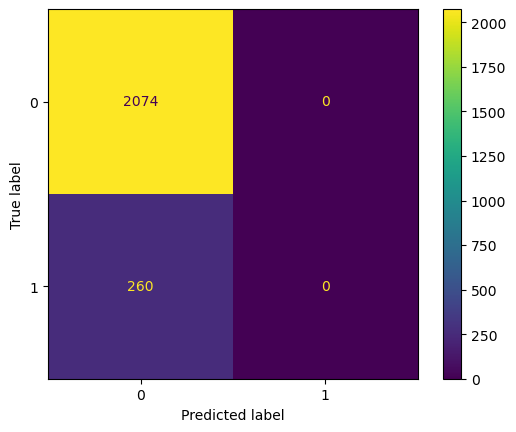

In [169]:
dummy_cm = confusion_matrix(y_train, dummy_model.predict(X_train))
ConfusionMatrixDisplay(dummy_cm).plot();

### 4.b. Decision Tree

#### 4.b.i. Baseline Decision Tree

In [206]:
dt_pipe = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('dt', DecisionTreeClassifier(random_state=1))
])


cv_eval_model(dt_pipe, X_train, y_train, X_test, y_test)

Training scores: {'fit_time': array([0.03461003, 0.03171182, 0.02759981, 0.02553391, 0.02645397]), 'score_time': array([0.0042448 , 0.00327134, 0.0019381 , 0.00149012, 0.00186229]), 'test_accuracy': array([0.85653105, 0.85438972, 0.88008565, 0.88008565, 0.88412017]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_precision': array([0.40963855, 0.4       , 0.46969697, 0.47142857, 0.48571429]), 'train_precision': array([1., 1., 1., 1., 1.])}
Mean training accuracy: 1.0
Mean training precision: 1.0
Mean validation data accuracy: 0.8710424497523228
Mean validation data precision: 0.4472956762113389


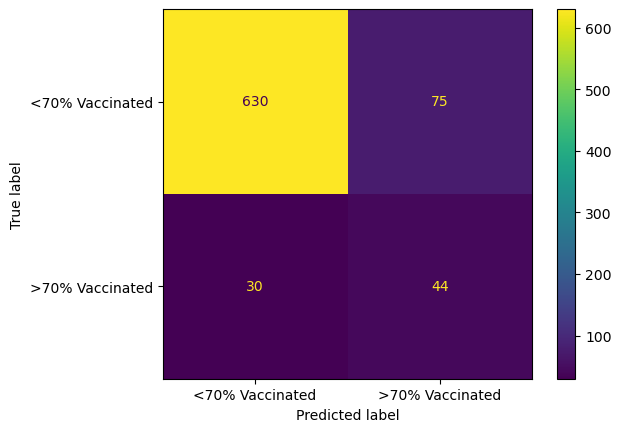

In [207]:
y_pred = dt_pipe.fit(X_train, y_train).predict(X_test)
plot_cm(y_test, y_pred)

In [208]:
get_feature_importances(dt_pipe['dt'], X)

,features,importances
0,per_gop,0.502467
7,BA,0.079743
5,MEDHHINC_2021,0.070693
8,IA,0.059181
10,MEDIAN_AGE_TOT,0.057416
1,per_dem,0.056549
4,PCTPOVALL_2021,0.043896
9,AAPI,0.037439
6,WA,0.034935
11,through_hs,0.026221


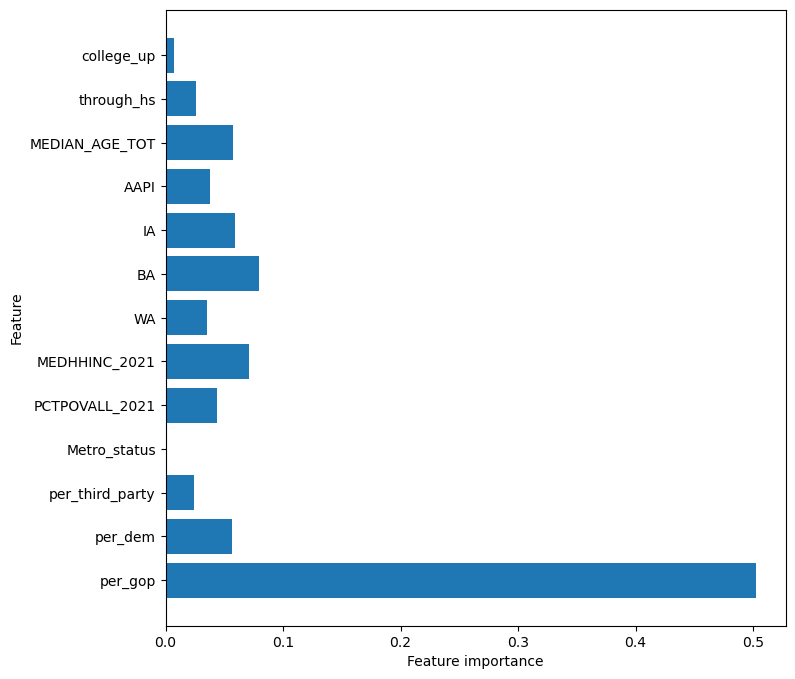

In [209]:
plot_feature_importances(dt_pipe['dt'], X)

#### 4.b.ii Decision Tree Gridsearch

In [204]:
dt_pipe = imbPipeline([
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE(random_state=1)),
    ('dt', DecisionTreeClassifier(random_state=1))
])

pipe_grid = {'smote__k_neighbors': [5, 10, 20],
                'dt__max_depth': [None, 1, 5, 10],
                'dt__min_samples_split': [2, 5, 10],
                'dt__min_samples_leaf': [1, 2, 5, 10],
                'dt__ccp_alpha': [0, .001, .01, .1, 1]}

gs_pipe_dt = GridSearchCV(dt_pipe, pipe_grid, cv=5, scoring=['accuracy', 'recall', 'precision'], refit='precision', n_jobs=-2, verbose=1, return_train_score=True)
gs_pipe_dt.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natehiatt/anaconda3/envs/learn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=1)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-2,
             param_grid={'dt__ccp_alpha': [0, 0.001, 0.01, 0.1, 1],
                         'dt__max_depth': [None, 1, 5, 10],
                         'dt__min_samples_leaf': [1, 2, 5, 10],
                         'dt__min_samples_split': [2, 5, 10],
                         'smote__k_neighbors': [5, 10, 20]},
             refit='precision', scoring=['accuracy', 'recall', 'precision'],
             verbose=1)

In [ ]:
def best_gs(gs_model):
    gs_model.best_params_
    gs_model.best_score_
    gs_model.best_estimator_

    y_pred = gs_model.best_estimator_.predict(X_test)
    precision = precision_score(y_test, y_pred)

## 5. Interpreting Our Results

## 6. Impact of the Model

## 7. Next Steps